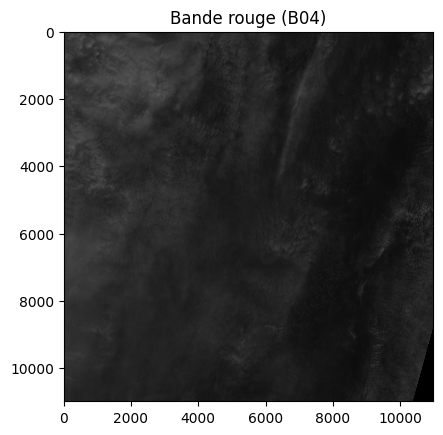

In [4]:
import rasterio
import matplotlib.pyplot as plt

url = "https://sentinel-s2-l1c.s3.amazonaws.com/tiles/31/U/FS/2022/3/1/0/B04.jp2"

with rasterio.open(url) as src:
    red = src.read(1)

plt.imshow(red, cmap="gray")
plt.title("Bande rouge (B04)")
plt.show()


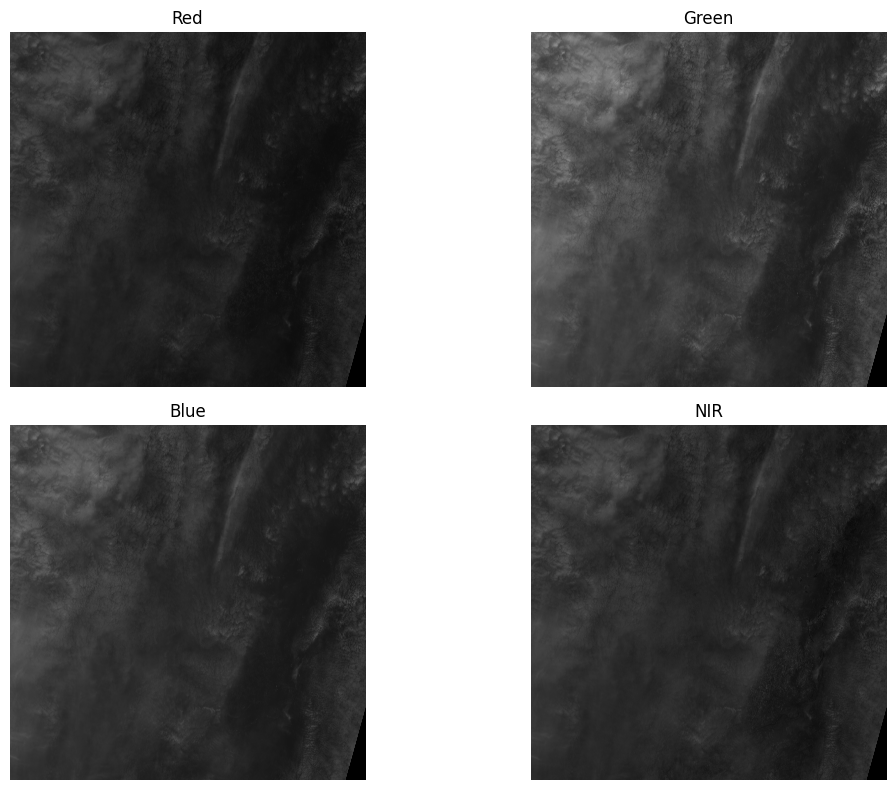

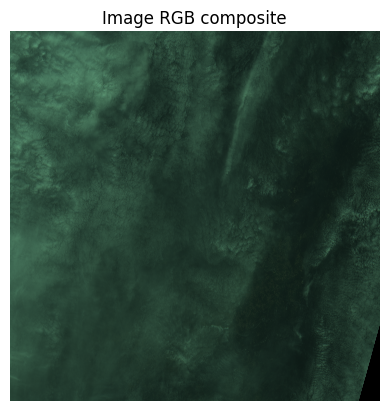

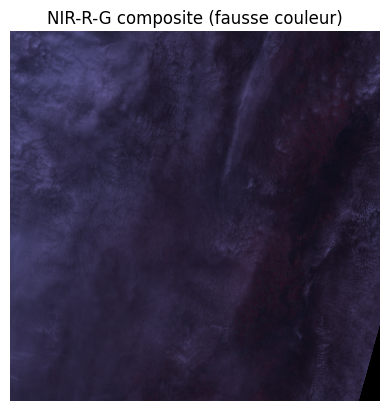

In [5]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# URLs AWS pour une tuile autour de Paris (31/U/FS), le 1 mars 2022
base_url = "https://sentinel-s2-l1c.s3.amazonaws.com/tiles/31/U/FS/2022/3/1/0/"
bands = {"Red": "B04.jp2", "Green": "B03.jp2", "Blue": "B02.jp2", "NIR": "B08.jp2"}

# Chargement des bandes
data = {}
for name, filename in bands.items():
    with rasterio.open(base_url + filename) as src:
        data[name] = src.read(1).astype(np.float32)


# Normalisation simple (0-1) pour affichage
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())


# Affichage individuel
plt.figure(figsize=(12, 8))
for i, (name, band) in enumerate(data.items()):
    plt.subplot(2, 2, i + 1)
    plt.imshow(normalize(band), cmap="gray")
    plt.title(name)
    plt.axis("off")
plt.tight_layout()
plt.show()

# RGB composite
rgb = np.stack([normalize(data["Red"]), normalize(data["Green"]), normalize(data["Blue"])], axis=-1)

plt.figure()
plt.imshow(rgb)
plt.title("Image RGB composite")
plt.axis("off")
plt.show()

# NIR-R-G composite (utile pour la végétation, l'eau, etc.)
nrg = np.stack([normalize(data["NIR"]), normalize(data["Red"]), normalize(data["Green"])], axis=-1)

plt.figure()
plt.imshow(nrg)
plt.title("NIR-R-G composite (fausse couleur)")
plt.axis("off")
plt.show()


In [17]:
import requests
from pathlib import Path

# Liste des dates et tuiles Sentinel-2 de la région parisienne
dates = ["2022-03-01", "2025-05-28", "2025-05-22", "2025-05-16", "2025-05-14", "2025-05-09", "2025-05-02"]
tiles = ["31UFS", "31UFT", "31UFU", "31UES", "31UET"]

bands = {"red": "B04.jp2", "green": "B03.jp2", "blue": "B02.jp2", "nir": "B08.jp2"}


# Fonction pour construire l'URL Sentinel-2 AWS
def build_url(tile_code: str, date: str, band_file: str) -> str:
    utm_zone = tile_code[:2]
    lat_band = tile_code[2]
    grid_square = tile_code[3:]
    year, month, day = date.split("-")
    return f"https://sentinel-s2-l1c.s3.amazonaws.com/tiles/{utm_zone}/{lat_band}/{grid_square}/{year}/{int(month)}/{int(day)}/0/{band_file}"


# Dossier racine
root_dir = Path(r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2")

for date in dates:
    for tile in tiles:
        for band, band_file in bands.items():
            url = build_url(tile, date, band_file)
            output_dir = root_dir / date / tile / band
            output_dir.mkdir(parents=True, exist_ok=True)
            output_path = output_dir / band_file

            if output_path.exists():
                print(f"[✔] {output_path.name} déjà présent.")
                continue

            print(f"[↓] {output_path.name} ({tile} - {date})...")
            try:
                response = requests.get(url, stream=True, timeout=20)
                response.raise_for_status()
                with open(output_path, "wb") as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                print(f"[✓] Téléchargé : {output_path}")
            except Exception as e:
                print(f"[✗] Erreur : {url}\n  → {e}")


[✔] B04.jp2 déjà présent.
[✔] B03.jp2 déjà présent.
[✔] B02.jp2 déjà présent.
[✔] B08.jp2 déjà présent.
[↓] B04.jp2 (31UFT - 2022-03-01)...
[✓] Téléchargé : C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2\2022-03-01\31UFT\red\B04.jp2
[↓] B03.jp2 (31UFT - 2022-03-01)...
[✓] Téléchargé : C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2\2022-03-01\31UFT\green\B03.jp2
[↓] B02.jp2 (31UFT - 2022-03-01)...
[✓] Téléchargé : C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2\2022-03-01\31UFT\blue\B02.jp2
[↓] B08.jp2 (31UFT - 2022-03-01)...
[✓] Téléchargé : C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2\2022-03-01\31UFT\nir\B08.jp2
[↓] B04.jp2 (31UFU - 2022-03-01)...
[✓] Téléchargé : C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2\2022-03-01\31UFU\red\B04.jp2
[↓] B03.jp2 (31UFU - 2022-03-01)...
[✓] Téléchargé : C:\Users\giand\OneDrive\Documents\_

In [15]:
from pathlib import Path


def build_dataset_from_inference(root: Path) -> list[dict]:
    dataset = []
    for date_dir in root.iterdir():
        if not date_dir.is_dir():
            continue
        for tile_dir in date_dir.iterdir():
            if not tile_dir.is_dir():
                continue

            entry = {}
            try:
                entry["red"] = str(next((tile_dir / "red").glob("B04.jp2")))
                entry["green"] = str(next((tile_dir / "green").glob("B03.jp2")))
                entry["blue"] = str(next((tile_dir / "blue").glob("B02.jp2")))
                entry["nir"] = str(next((tile_dir / "nir").glob("B08.jp2")))
                dataset.append(entry)
            except StopIteration:
                print(f"[!] Incomplet, ignoré : {tile_dir}")
                continue

    return dataset


import csv


# Utilisation
dataset = build_dataset_from_inference(root_dir)

print(f"{len(dataset)} entrées valides trouvées.")
print(dataset[0])  # aperçu

csv_path = Path("dataset.csv")

with open(csv_path, mode="w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["red", "green", "blue", "nir"])
    writer.writeheader()
    for row in dataset:
        writer.writerow(row)

print(f"[✓] Fichier CSV enregistré à : {csv_path.resolve()}")


[!] Incomplet, ignoré : C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2\2022-04-01\31UFR
[!] Incomplet, ignoré : C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2\2022-04-01\31UFS
[!] Incomplet, ignoré : C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2\2025-05-22\31UFR
[!] Incomplet, ignoré : C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2\2025-05-22\31UFS
[!] Incomplet, ignoré : C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2\2025-05-28\31UFR
[!] Incomplet, ignoré : C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2\2025-05-28\31UFS
4 entrées valides trouvées.
{'red': 'C:\\Users\\giand\\OneDrive\\Documents\\__packages__\\_perso\\satellite_data\\sentinel2\\2022-03-01\\31UFR\\red\\B04.jp2', 'green': 'C:\\Users\\giand\\OneDrive\\Documents\\__packages__\\_perso\\satellite_data\\sentinel2\\2022-03-01\\31UFR\\gree

                                                 red  \
0  C:\Users\giand\OneDrive\Documents\__packages__...   
1  C:\Users\giand\OneDrive\Documents\__packages__...   
2  C:\Users\giand\OneDrive\Documents\__packages__...   
3  C:\Users\giand\OneDrive\Documents\__packages__...   

                                               green  \
0  C:\Users\giand\OneDrive\Documents\__packages__...   
1  C:\Users\giand\OneDrive\Documents\__packages__...   
2  C:\Users\giand\OneDrive\Documents\__packages__...   
3  C:\Users\giand\OneDrive\Documents\__packages__...   

                                                blue  \
0  C:\Users\giand\OneDrive\Documents\__packages__...   
1  C:\Users\giand\OneDrive\Documents\__packages__...   
2  C:\Users\giand\OneDrive\Documents\__packages__...   
3  C:\Users\giand\OneDrive\Documents\__packages__...   

                                                 nir  
0  C:\Users\giand\OneDrive\Documents\__packages__...  
1  C:\Users\giand\OneDrive\Documents\__packages

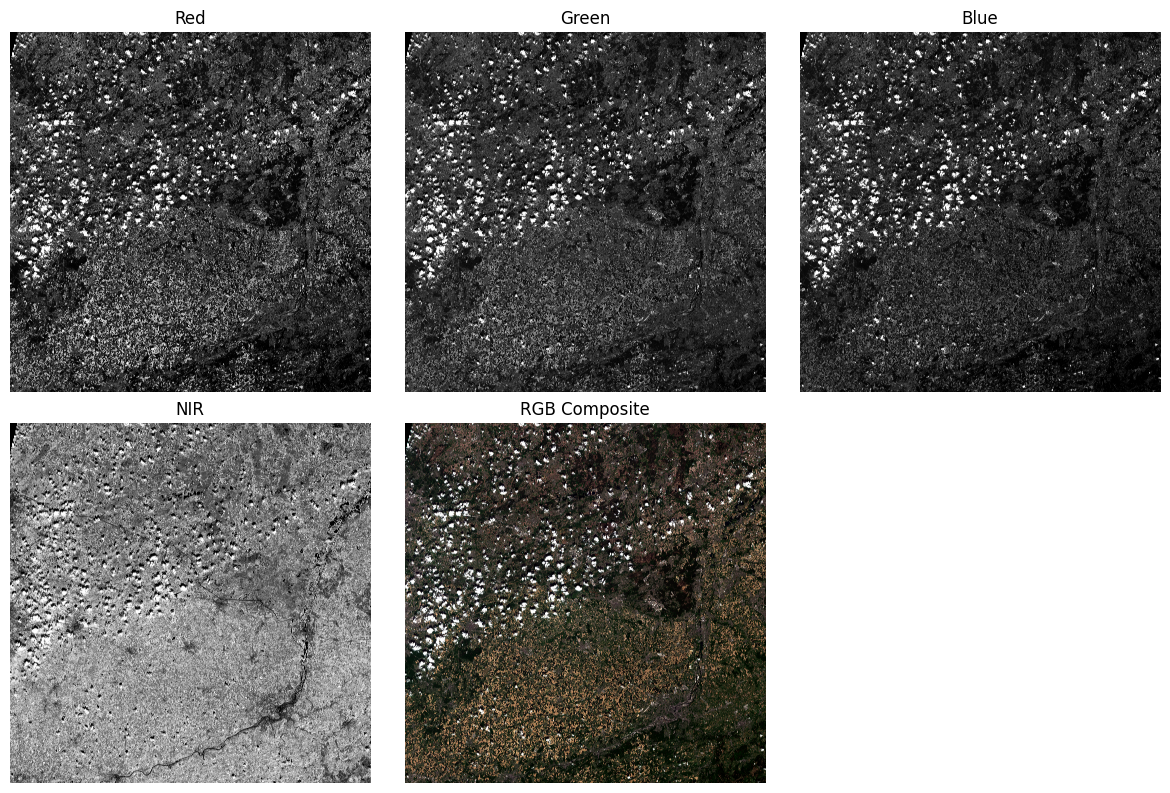

In [ ]:
import csv
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from pathlib import Path

import pandas as pd

df = pd.read_csv("dataset.csv")

sample = df.iloc[-1]


# Charger les images
def load_band(path):
    with rasterio.open(path) as src:
        return src.read(1).astype(np.float32)


red = load_band(sample["red"])
green = load_band(sample["green"])
blue = load_band(sample["blue"])
nir = load_band(sample["nir"])


# Fonction de normalisation pour affichage
def normalize_stretch(img, min_percent=2, max_percent=98):
    min_val = np.percentile(img, min_percent)
    max_val = np.percentile(img, max_percent)
    return np.clip((img - min_val) / (max_val - min_val), 0, 1)


# Normaliser les bandes pour affichage
red_n = normalize_stretch(red)
green_n = normalize_stretch(green)
blue_n = normalize_stretch(blue)
nir_n = normalize_stretch(nir)

# Affichage
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(red_n, cmap="gray")
plt.title("Red")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(green_n, cmap="gray")
plt.title("Green")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(blue_n, cmap="gray")
plt.title("Blue")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(nir_n, cmap="gray")
plt.title("NIR")
plt.axis("off")

# Composite RGB
rgb = np.stack([red_n, green_n, blue_n], axis=-1)
plt.subplot(2, 3, 5)
plt.imshow(rgb)
plt.title("RGB Composite")
plt.axis("off")

plt.tight_layout()
plt.show()


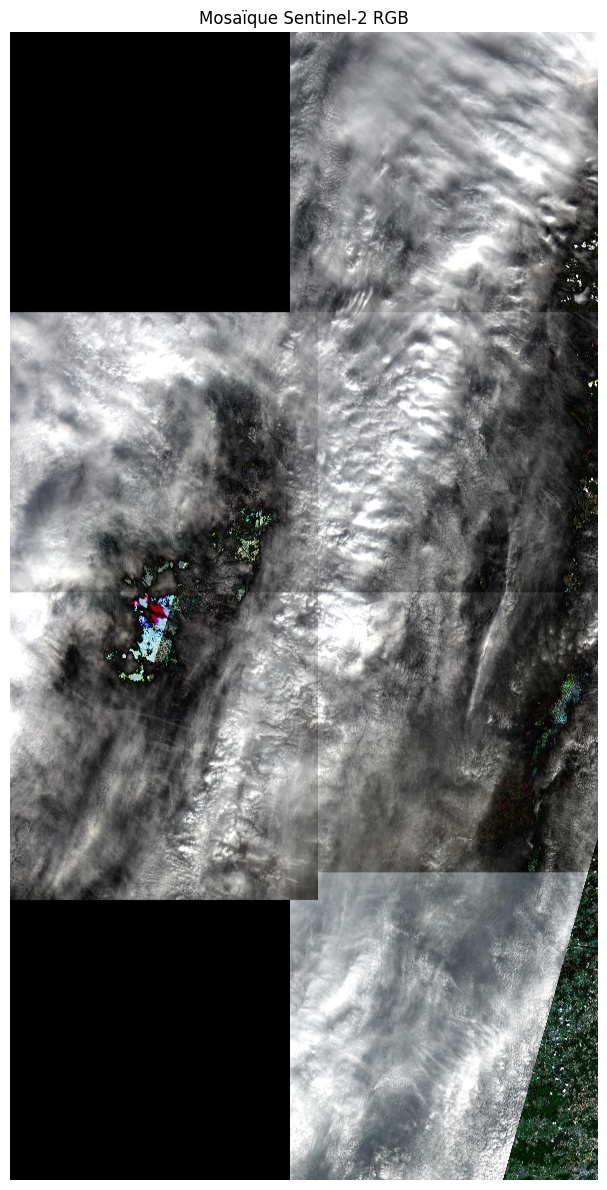

In [19]:
import rasterio
from rasterio.merge import merge
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


# Récupérer toutes les combinaisons RGB possibles dans l'arborescence
def get_rgb_triplets(root: Path):
    rgb_sets = []
    for date_dir in root.iterdir():
        for tile_dir in date_dir.iterdir():
            red = tile_dir / "red" / "B04.jp2"
            green = tile_dir / "green" / "B03.jp2"
            blue = tile_dir / "blue" / "B02.jp2"
            if red.exists() and green.exists() and blue.exists():
                rgb_sets.append((red, green, blue))
    return rgb_sets


# Charger chaque tuile RGB en une image 3 canaux
def load_rgb_image(red_path, green_path, blue_path):
    with rasterio.open(red_path) as rsrc:
        red = rsrc.read(1).astype(np.float32)
        profile = rsrc.profile
    with rasterio.open(green_path) as gsrc:
        green = gsrc.read(1).astype(np.float32)
    with rasterio.open(blue_path) as bsrc:
        blue = bsrc.read(1).astype(np.float32)

    rgb = np.stack([red, green, blue], axis=0)
    return rgb, profile


# Normalisation par bande (stretch)
def normalize_band(band):
    p2, p98 = np.percentile(band, (2, 98))
    return np.clip((band - p2) / (p98 - p2), 0, 1)


# Chargement des tuiles
root_dir = Path(r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2")
triplets = get_rgb_triplets(root_dir)

srcs = []
profiles = []

for red, green, blue in triplets:
    rgb, profile = load_rgb_image(red, green, blue)
    src = np.stack(
        [
            normalize_band(rgb[0]),
            normalize_band(rgb[1]),
            normalize_band(rgb[2]),
        ],
        axis=0,
    )
    memfile = rasterio.io.MemoryFile()
    with memfile.open(
        driver="GTiff",
        width=src.shape[2],
        height=src.shape[1],
        count=3,
        dtype="float32",
        transform=profile["transform"],
        crs=profile["crs"],
    ) as dst:
        dst.write(src)
    srcs.append(memfile.open())
    profiles.append(profile)

# Mosaïquage
mosaic, out_transform = merge(srcs, method="first")

# Affichage
rgb_mosaic = np.transpose(mosaic, (1, 2, 0))  # (bands, h, w) -> (h, w, bands)
plt.figure(figsize=(12, 12))
plt.imshow(rgb_mosaic)
plt.title("Mosaïque Sentinel-2 RGB")
plt.axis("off")
plt.tight_layout()
plt.show()
